In [2]:
import pandas as pd
import unidecode
import re
import nltk
import gensim
import numpy as np
import keras
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.layers import Embedding
from keras.models import Sequential
import sklearn.metrics as metric
import itertools
import pickle
import collections
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from keras.models import model_from_json
%matplotlib inline

/home/barbabra/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load Data

In [3]:
paths = {
    "dev":"../data/macmorpho-v3/macmorpho-dev.txt",
    "test":"../data/macmorpho-v3/macmorpho-test.txt",
    "train":"../data/macmorpho-v3/macmorpho-train.txt",
}

In [4]:
#load data
sentences = []
for p in paths.values():
    file = open(p, "r")
    sentences = sentences + file.readlines()
    file.close()
data = pd.DataFrame()
data['sentences'] = sentences

In [5]:
len(data)

49932

In [6]:
data.head()

,sentences
0,"Ainda_ADV em_PREP dezembro_N de_PREP 1990_N ,_..."
1,"Porém_KC ,_PU como_KS a_ART previsão_N indica_..."
2,"""_PU O_ART crescimento_N é_V expressivo_ADJ ma..."
3,O_ART programa_N atende_V ainda_ADV as_ART cul...
4,"de_PREP qualquer_PROADJ maneira_N ,_PU toda_PR..."


# Pre-processing

In [7]:
def remove_accents(sentence):
    return unidecode.unidecode(sentence)

In [8]:
def remove_character(sentence):
    return re.sub(' +',' ', (sentence.replace("\n", " ")).replace("\t", " "))

In [9]:
def pre_processing(sentence):
    sentence = remove_character(sentence)
    sentence = remove_accents(sentence)
    sentence = sentence.lower()
    return sentence

In [10]:
#pre-processing
data["sentences"] = data["sentences"].map(pre_processing)

In [11]:
#get text
data["corpus"] = data.loc[:, "sentences"].apply(lambda x : (" ".join([y.split("_")[0] for y in x.strip().split(" ")])).strip())

In [12]:
# get tags
data["tags"] = data.loc[:, "sentences"].apply(lambda x : (" ".join([y.split("_")[1] for y in x.strip().split(" ")])).strip())

In [13]:
#apply token
data["corpus"] = data.loc[:, "corpus"].apply(lambda x : nltk.word_tokenize(x))
data["tags"] = data.loc[:, "tags"].apply(lambda x : nltk.word_tokenize(x))

In [14]:
data.head()

,sentences,corpus,tags
0,"ainda_adv em_prep dezembro_n de_prep 1990_n ,_...","[ainda, em, dezembro, de, 1990, ,, foi, editad...","[adv, prep, n, prep, n, pu, v, pcp, art, adj, ..."
1,"porem_kc ,_pu como_ks a_art previsao_n indica_...","[porem, ,, como, a, previsao, indica, entrada,...","[kc, pu, ks, art, n, v, n, prep, n, adj, pu, v..."
2,"""_pu o_art crescimento_n e_v expressivo_adj ma...","[``, o, crescimento, e, expressivo, mas, ,, me...","[pu, art, n, v, adj, kc, pu, pden, pden, pu, v..."
3,o_art programa_n atende_v ainda_adv as_art cul...,"[o, programa, atende, ainda, as, culturas, de,...","[art, n, v, adv, art, n, prep, n, pu, adj, kc,..."
4,"de_prep qualquer_proadj maneira_n ,_pu toda_pr...","[de, qualquer, maneira, ,, toda, essa, ``, inf...","[prep, proadj, n, pu, proadj, proadj, pu, n, p..."


# Embedding

In [15]:
data.columns

Index(['sentences', 'corpus', 'tags'], dtype='object')

## Phrases and Phraser

In [16]:
corpus = data.corpus.values
bigram_corpus_phrases = gensim.models.Phrases(corpus)
bigram_corpus = bigram_corpus_phrases[corpus]

/home/barbabra/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [17]:
size_emb = 300
model_word2vec = gensim.models.word2vec.Word2Vec(bigram_corpus, min_count=1, workers=4, seed=123, size=size_emb)

/home/barbabra/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [18]:
len(model_word2vec.wv.vocab)

56252

In [19]:
def create_dict_embedding(word2vec):
    embeddings_dict = {}
    #get size dimension
    size_vec = word2vec.wv.vector_size
    #create disctionary
    for word in list(word2vec.wv.vocab.keys()):
        embeddings_dict[word] = word2vec.wv[word] 
    return embeddings_dict

In [20]:
def get_embeddings(word2vec):
    embeddings_dict = create_dict_embedding(word2vec)
    size = len(embeddings_dict)
    embedding_matrix = np.ndarray((size, word2vec.wv.vector_size), dtype='float32')
    wv_map = {}
    pos = 0
    for i, (word, vector) in enumerate(embeddings_dict.items()):
        pos = i
        wv_map[word] = pos
        embedding_matrix[pos] = vector
    return embedding_matrix, wv_map

# Split data: Train, Test and Validation

In [21]:
data = shuffle(data, random_state=0)

In [22]:
corpus = data.corpus.values
tags = data.tags.values

In [23]:
X_train, X_test, y_train, y_test = train_test_split(corpus, tags, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

# Preparing data
- padding max_sentence_length  with 0
- index words
- index tags

In [24]:
embeddings, words_index = get_embeddings(model_word2vec)

In [25]:
tags_index = {}
i = 1
for tags in data.tags.values:
    for tag in tags:
        if(tag not in tags_index.keys()):
            tags_index[tag] = i
            i = i + 1

In [26]:
max_sentence_length = int(data["corpus"].map(len).describe()['max'] + 1)
max_sentence_length

249

## Index

In [27]:
# SET sentence index and padding
def index_words(sentences, max_sentence_length, words_index):    
    print("indexing sentences...")
    text_max = False
    sent_words = []

    sentences_words_indexed = np.zeros((len(sentences), max_sentence_length), dtype='int32')

    for i, sentence in enumerate(sentences):
        print(str(i)+"/"+str(len(sentences)))
        text_max = False
        sent_words = []
        for word in sentence:
            if(word not in set(words_index.keys())):
                continue
            sent_words.append(words_index[word])
            if(len(sent_words) >= max_sentence_length):
                text_max = True
                break
        if(text_max == False):
            sent_words = np.pad(sent_words, (0, max_sentence_length - len(sent_words) % max_sentence_length), 'constant')
        sentences_words_indexed[i] = sent_words
    return sentences_words_indexed

In [28]:
len(X_train)

31956

In [29]:
len(X_train[:200])

200

In [54]:
X_train_inx = pickle.load(open("data/X_train_index.p", "rb"))
y_train_inx = pickle.load(open("data/y_train_index.p", "rb"))

X_test_inx = pickle.load(open("data/X_test_index.p", "rb"))
y_test_inx = pickle.load(open("data/y_test_index.p", "rb"))

X_val_inx = pickle.load(open("data/X_val_index.p", "rb"))
y_val_inx = pickle.load(open("data/y_val_index.p", "rb"))


In [31]:
#train
print("traing")
X_train_inx = index_words(X_train, max_sentence_length, words_index)
y_train_inx = index_words(y_train, max_sentence_length, tags_index)

pickle.dump(X_train_inx, open( "data/X_train_index.p", "wb" ) )
pickle.dump(y_train_inx, open( "data/y_train_index.p", "wb" ) )

#test
print("test")
X_test_inx = index_words(X_test, max_sentence_length, words_index)
y_test_inx = index_words(y_test, max_sentence_length, tags_index)

pickle.dump(X_test_inx, open( "data/X_test_index.p", "wb" ) )
pickle.dump(y_test_inx, open( "data/y_test_index.p", "wb" ) )

#validaotion
print("validation")
X_val_inx = index_words(X_val, max_sentence_length, words_index)
y_val_inx = index_words(y_val, max_sentence_length, tags_index)

pickle.dump(X_val_inx, open( "data/X_val_index.p", "wb" ) )
pickle.dump(y_val_inx, open( "data/y_val_index.p", "wb" ) )

traing
indexing sentences...
0/31956
1/31956
2/31956
3/31956
4/31956
5/31956
6/31956
7/31956
8/31956
9/31956
10/31956
11/31956
12/31956
13/31956
14/31956
15/31956
16/31956
17/31956
18/31956
19/31956
20/31956
21/31956
22/31956
23/31956
24/31956
25/31956
26/31956
27/31956
28/31956
29/31956
30/31956
31/31956
32/31956
33/31956
34/31956
35/31956
36/31956
37/31956
38/31956
39/31956
40/31956
41/31956
42/31956
43/31956
44/31956
45/31956
46/31956
47/31956
48/31956
49/31956
50/31956
51/31956
52/31956
53/31956
54/31956
55/31956
56/31956


KeyboardInterrupt: 

In [31]:
y_test_inx = np_utils.to_categorical(y_test_inx)

In [32]:
y_train_inx = np_utils.to_categorical(y_train_inx)

In [33]:
y_val_inx = np_utils.to_categorical(y_val_inx)

# Model

In [32]:
model = keras.models.Sequential()
model

In [33]:
embeddings.shape

(56252, 300)

In [34]:
max_sentence_length

249

In [35]:
from keras import backend as K
 
def ignore_class_accuracy(to_ignore=0):
    def ignore_accuracy(y_true, y_pred):
        y_true_class = K.argmax(y_true, axis=-1)
        y_pred_class = K.argmax(y_pred, axis=-1)
 
        ignore_mask = K.cast(K.not_equal(y_pred_class, to_ignore), 'int32')
        matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
        accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask), 1)
        return accuracy
    return ignore_accuracy

In [36]:
#https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
def embeddings_layer(max_length, embeddings, trainable=False):

    vocab_size = embeddings.shape[0]
    embedding_size = embeddings.shape[1]

    _embedding = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_size,
        input_length=max_length,
        trainable=False,
        weights=[embeddings]
    )

    return _embedding

In [37]:
model = Sequential()
model.add(embeddings_layer(max_sentence_length, embeddings))
model.add(keras.layers.LSTM(300, return_sequences=True))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(len(tags_index)+1, activation='softmax'))

In [38]:
#plot_model(model, to_file='graficos/model_plot.png', show_shapes=True, show_layer_names=True)

## Compile

In [39]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy', 'categorical_accuracy',ignore_class_accuracy(0)])

In [40]:
history =  model.fit(
            X_train_inx,
            y_train_inx,
            batch_size = 32,
            epochs=300,
            validation_data = (X_val_inx, y_val_inx),
            callbacks = [
                keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    min_delta=0.0001,
                    patience=10,
                    verbose=0,
                    mode='min'
                 )
            ]
        )

Train on 31956 samples, validate on 7989 samples
Epoch 1/300
31956/31956 [==============================] - 692s 22ms/step - loss: 0.1053 - acc: 0.9716 - categorical_accuracy: 0.9716 - ignore_accuracy: 0.6579 - val_loss: 0.0619 - val_acc: 0.9817 - val_categorical_accuracy: 0.9817 - val_ignore_accuracy: 0.7625
Epoch 2/300
31956/31956 [==============================] - 692s 22ms/step - loss: 0.0652 - acc: 0.9815 - categorical_accuracy: 0.9815 - ignore_accuracy: 0.7598 - val_loss: 0.0552 - val_acc: 0.9837 - val_categorical_accuracy: 0.9837 - val_ignore_accuracy: 0.7890
Epoch 3/300
31956/31956 [==============================] - 692s 22ms/step - loss: 0.0594 - acc: 0.9832 - categorical_accuracy: 0.9832 - ignore_accuracy: 0.7806 - val_loss: 0.0522 - val_acc: 0.9847 - val_categorical_accuracy: 0.9847 - val_ignore_accuracy: 0.8008
Epoch 4/300
31956/31956 [==============================] - 692s 22ms/step - loss: 0.0560 - acc: 0.9840 - categorical_accuracy: 0.9840 - ignore_accuracy: 0.7918 - val

# Save Model

In [41]:
model_json = model.to_json()
with open("results/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("results/model.h5")
print("Saved model to disk")

Saved model to disk


# Load Model

In [34]:
# load json and create model
json_file = open('results/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("results/model.h5")
print("Loaded model from disk")

Loaded model from disk


# Evaluate Model

In [35]:
predicted_test = model.predict(X_test_inx)

In [36]:
tags = []
for predict in predicted_test:
    for t in predict:
        tags.append(np.argmax(t))
len(np.unique(tags))

24

In [37]:
#convert_matrix_from_categorical
def decoder_matrix(matrix):
    matrix_ = np.zeros((matrix.shape[0], matrix.shape[1]), dtype='int32')

    for i, mat in enumerate(matrix):
        tags = []
        for m in mat:
            tags.append(np.argmax(m))
        tags = np.array(tags)
        matrix_[i] = tags
    return matrix_

In [38]:
y_predict = decoder_matrix(predicted_test)
y_real = decoder_matrix(y_test_inx)

In [39]:
#Removing padding of arrays for analyse
y_predict_wp = np.zeros(y_predict.shape[0], dtype=object) #y_predict withou predictd
y_real_wp = np.zeros(y_real.shape[0], dtype=object) #y_real withou predictd

for i, y in enumerate(y_test):
    size = len(y)
    y_predict_wp[i] = y_predict[i][:size]
    y_real_wp[i] = y_real[i][:size]

In [40]:
def reshape(matrix):
    array = []
    for elements in matrix:
        for e in elements:
            array.append(e)
    return array

In [41]:
y_predict = reshape(y_predict_wp)
y_real = reshape(y_real_wp)

## Metrics

### Accuracy

In [46]:
metric.accuracy_score(y_predict, y_real)*100

83.5237840754887

### History

In [50]:
def plot_history(value, epochs, title):
    f, ax = plt.subplots(1,1,figsize=(4.5,3))
    ax.plot(history.history[value], color="green")
    ax.set_xlabel("Epochs", fontweight='bold')
    ax.set_ylabel(value.title() ,fontweight='bold')
    #ax.set_xticks(np.arange(0,epochs+1))f
    ax.set_title(title.title(), fontweight='bold')
    f.tight_layout()
    plt.savefig("graficos/"+value+".pdf", format='pdf', dpi=400)  

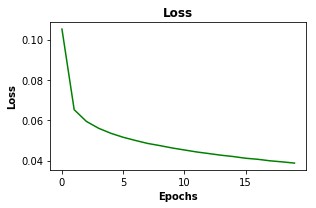

In [51]:
plot_history("loss", len(history.history["loss"]), "Loss")

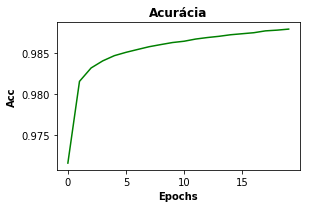

In [52]:
plot_history("acc", len(history.history["acc"]), "Acurácia")

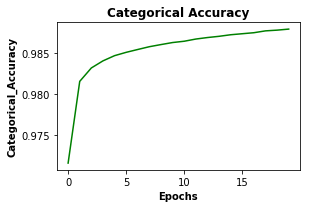

In [53]:
plot_history("categorical_accuracy", len(history.history["categorical_accuracy"]), "Categorical Accuracy")

### Report

In [77]:
report = metric.classification_report(y_predict,y_real)

/home/barbabra/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/barbabra/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [79]:
len(y_predict)

190863

In [84]:
Counter(y_test_inx.reshape(-1))

Counter({1: 13865,
         3: 18335,
         6: 20152,
         2: 40679,
         15: 4639,
         11: 2323,
         10: 18659,
         12: 3337,
         5: 11703,
         9: 8694,
         4: 28005,
         0: 2295900,
         16: 3055,
         7: 2464,
         8: 4938,
         19: 2219,
         13: 3930,
         18: 1149,
         14: 1282,
         17: 336,
         20: 150,
         24: 528,
         21: 204,
         26: 17,
         23: 51,
         22: 107,
         25: 42})

In [87]:
tags_index

{'art': 1,
 'n': 2,
 'nprop': 3,
 'pu': 4,
 'prep+art': 5,
 'v': 6,
 'ks': 7,
 'adv': 8,
 'adj': 9,
 'prep': 10,
 'propess': 11,
 'num': 12,
 'pcp': 13,
 'prosub': 14,
 'kc': 15,
 'proadj': 16,
 'prep+proadj': 17,
 'pden': 18,
 'pro-ks': 19,
 'prep+prosub': 20,
 'adv-ks': 21,
 'prep+propess': 22,
 'in': 23,
 'cur': 24,
 'prep+pro-ks': 25,
 'prep+adv': 26}

In [85]:
print(report)

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       257
          1       0.95      0.87      0.91     15104
          2       0.86      0.80      0.83     43678
          3       0.68      0.72      0.70     17169
          4       0.96      0.96      0.96     28189
          5       0.91      0.92      0.92     11559
          6       0.86      0.80      0.83     21728
          7       0.74      0.87      0.80      2094
          8       0.67      0.85      0.75      3933
          9       0.62      0.63      0.62      8596
         10       0.91      0.88      0.89     19451
         11       0.86      0.93      0.89      2161
         12       0.74      0.83      0.78      2984
         13       0.38      0.75      0.50      1990
         14       0.27      0.86      0.41       408
         15       0.84      0.88      0.86      4418
         16       0.83      0.81      0.82      3141
         17       0.74      0.84      0.79   

In [55]:
pickle.dump(report, open( "results/report_metrics.p", "wb" ))

### Confusion matrix

In [56]:
cm = metric.confusion_matrix(y_predict, y_real)#.shape

In [57]:
#Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes, tipo,
                          normalize,
                          title='Matriz de Confusão',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure(figsize=(12,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=16)
    plt.colorbar(pad=0.01)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=80,fontsize=12)
    plt.yticks(tick_marks, classes,fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.rcParams.update({'font.size': 8})
    plt.ylabel('Tag Verdadeira', fontsize=14)
    plt.xlabel('Tag Predita',fontsize=14)
    plt.tight_layout()
    plt.savefig("graficos/confusion_matrix_"+(tipo)+".pdf", format='pdf', dpi=400)  

Confusion matrix, without normalization


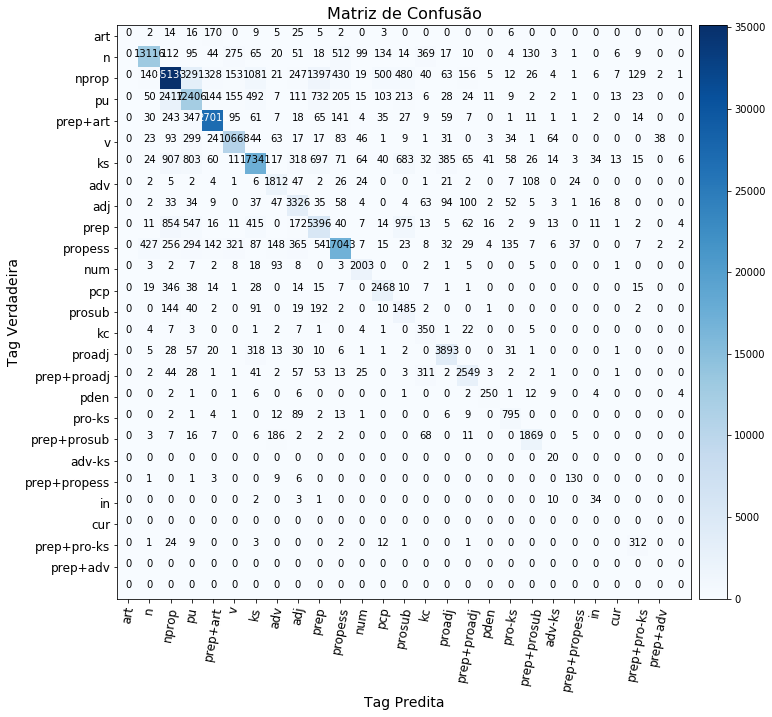

In [58]:
plot_confusion_matrix(cm, list(tags_index.keys()),"1_not_normed", False)

Confusion matrix, without normalization


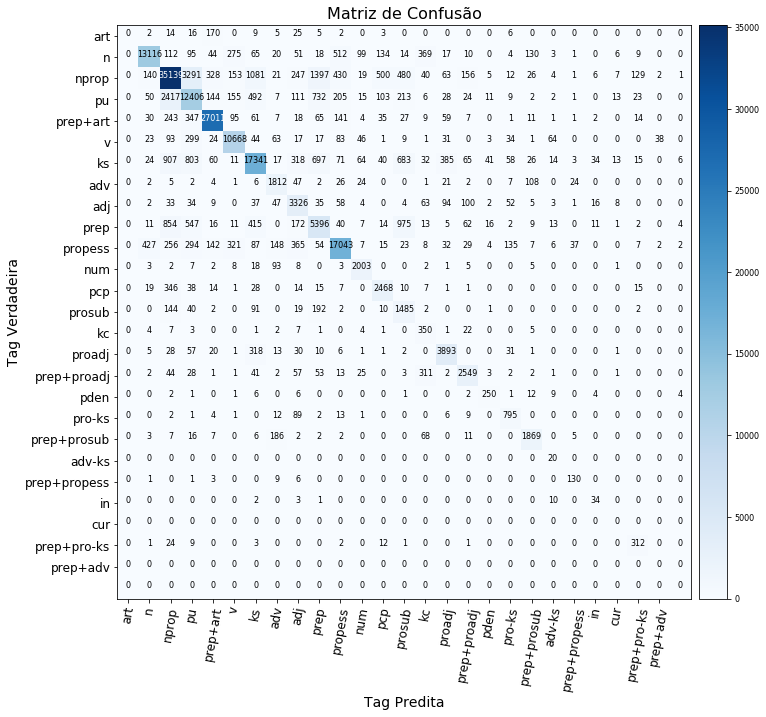

In [62]:
plot_confusion_matrix(cm, list(tags_index.keys()),"2_not_normed", False)

/home/barbabra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Normalized confusion matrix


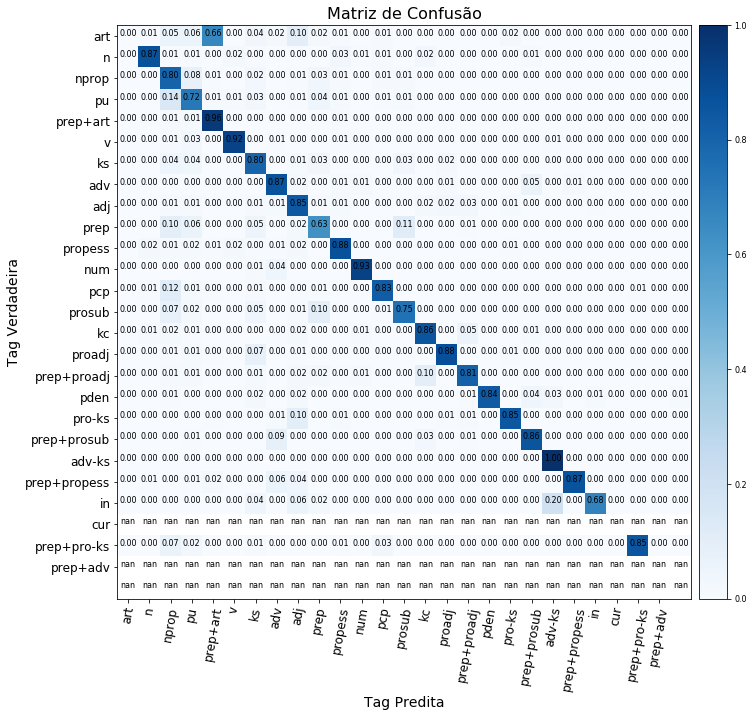

In [61]:
plot_confusion_matrix(cm, list(tags_index.keys()),"1_normed", True)

### Histogram y_real and y_predict

In [43]:
def plot_histogram(data, xlabel, ylabel, title, tipo):
    f, ax = plt.subplots(1,1,figsize=(3.5,2.5))
    ax.hist(data, facecolor='g', alpha=0.8, bins=26)
    ax.set_xlabel(xlabel, fontweight='bold')
    ax.set_ylabel(ylabel ,fontweight='bold')
    ax.set_title(title.title(), fontweight='bold')
    f.tight_layout()
    plt.grid(True)
    plt.savefig("graficos/"+title + "_"+tipo+".pdf", format='pdf', dpi=400)  

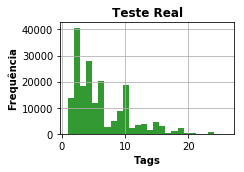

In [44]:
plot_histogram(y_real, "Tags", "Frequência", "Teste Real", "real")

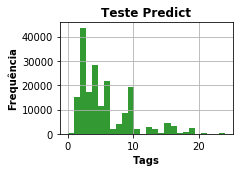

In [45]:
plot_histogram(y_predict, "Tags", "Frequência", "Teste Predict", "predict")